Getting Started with GDELT + Google Cloud Datalab: Simple Network Visualizations
---
This Datalab IPython notebook walks you through the basics of visualizing network diagrams based on the GDELT Global Knowledge Graph using Google Cloud Datalab, adapting the network tutorial from http://blog.gdeltproject.org/google-bigquery-gkg-2-0-sample-queries/. 
* You can download notebook file for this tutorial to follow along from the GDELT Blog at http://blog.gdeltproject.org/getting-started-with-gdelt-google-cloud-datalab-simple-network-visualizations/
* Also check out the tutorial on creating simple timelines of GDELT using Datalab at http://blog.gdeltproject.org/getting-started-with-gdelt-google-cloud-datalab-simple-timelines/
* Learn more about the GDELT Project (http://gdeltproject.org/) and see other recent GDELT news on the GDELT Blog (http://blog.gdeltproject.org/)
* You can right-click on all of the images on this page to open them in a new browser tab at a much larger size to make the text more readable.

Special thanks to Felipe Hoffa  (https://twitter.com/felipehoffa) for all of his help in creating these examples.

In [23]:
#first install networkx module

In [24]:
%%bash
pip install networkx

Cleaning up...


In [25]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import gcp.bigquery as bq

In [26]:
%%sql --module gkgnetwork

SELECT a.name, b.name, COUNT(*) as count
FROM (FLATTEN(
SELECT GKGRECORDID, UNIQUE(REGEXP_REPLACE(SPLIT(V2Persons,';'), r',.*', '')) name
FROM [gdelt-bq:gdeltv2.gkg] 
WHERE DATE>20150302000000 and DATE < 20150304000000 and V2Persons like '%Tsipras%'
,name)) a
JOIN EACH (
SELECT GKGRECORDID, UNIQUE(REGEXP_REPLACE(SPLIT(V2Persons,';'), r',.*', '')) name
FROM [gdelt-bq:gdeltv2.gkg] 
WHERE DATE>20150302000000 and DATE < 20150304000000 and V2Persons like '%Tsipras%'
) b
ON a.GKGRECORDID=b.GKGRECORDID
WHERE a.name<b.name
GROUP EACH BY 1,2
ORDER BY 3 DESC
LIMIT 250

In [27]:
results=bq.Query(gkgnetwork).to_dataframe()

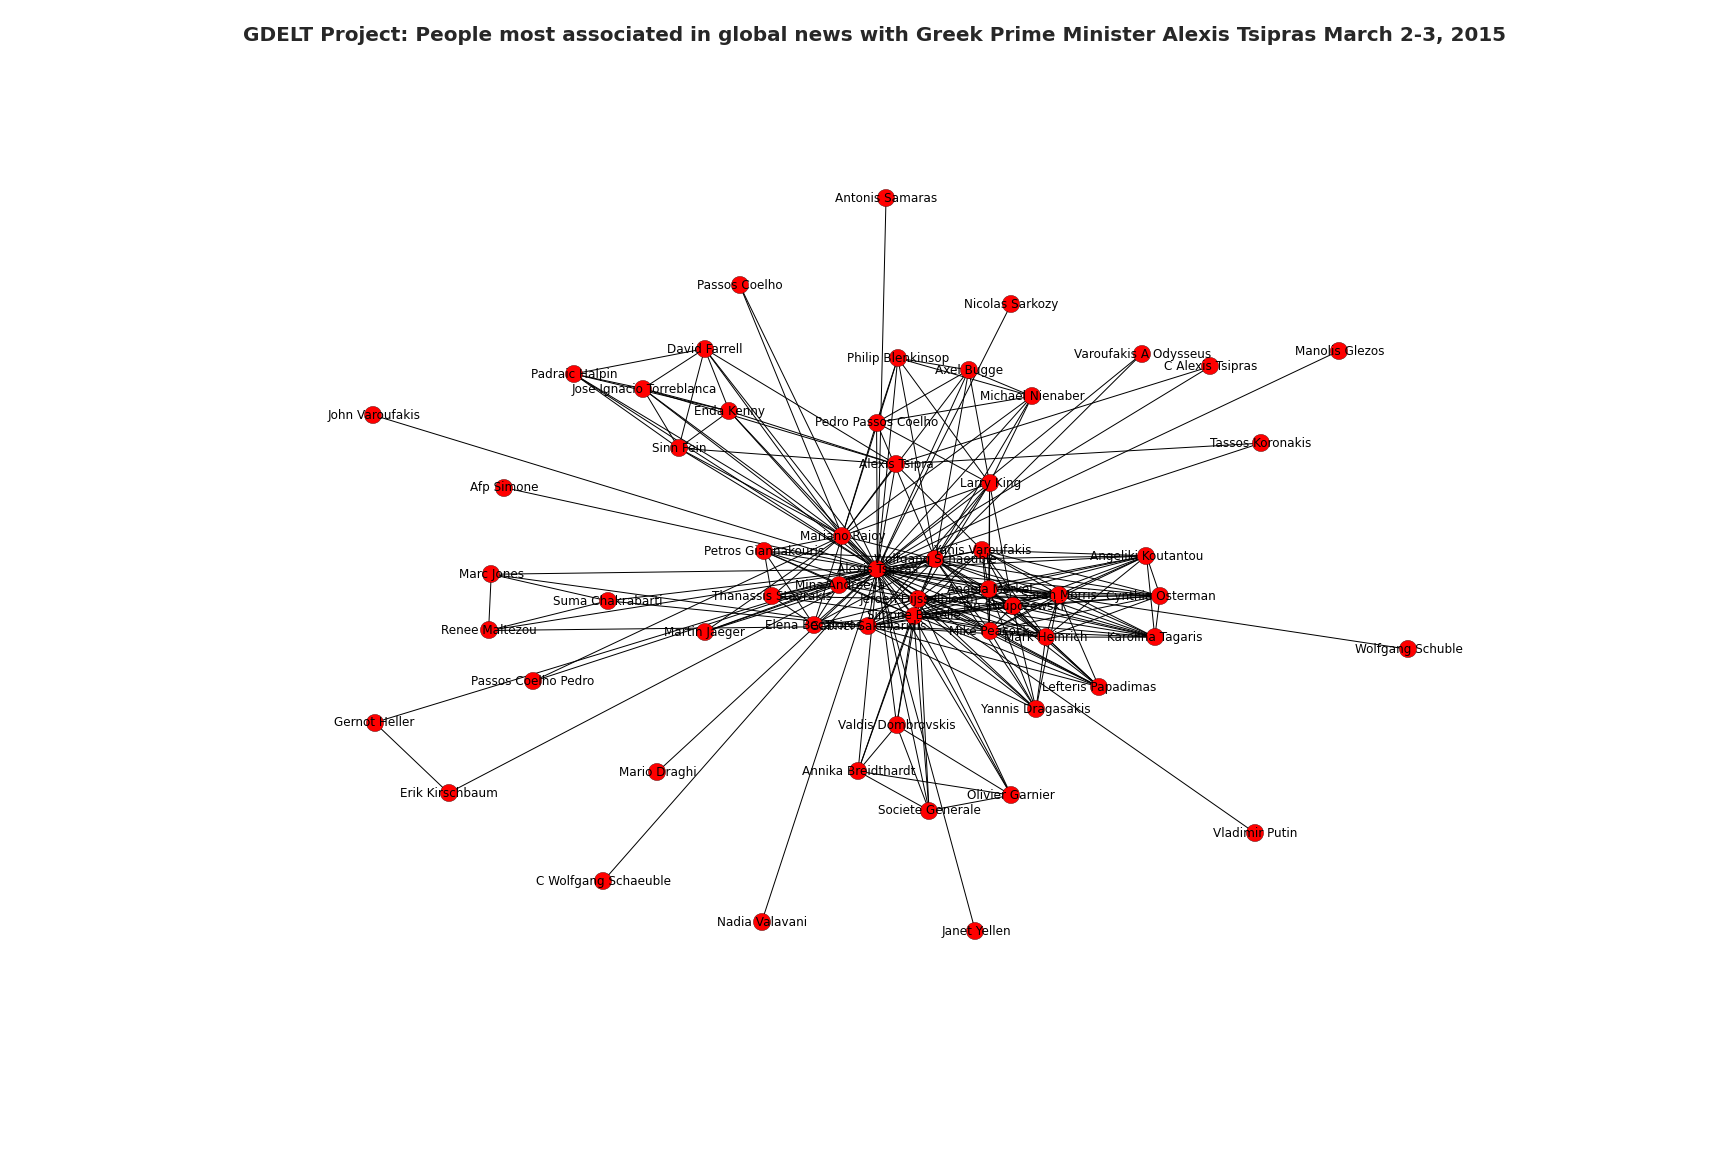

In [62]:
#now we'll make a very basic network display and manually filter out edges with the misspelling "Alexa" to get rid of that isolate cluster

g=nx.Graph()

for r in results.values:
  if 'Alexa' in r[0] or 'Alexa' in r[1]:
    continue
  g.add_edge(r[0],r[1], weight=r[2]/10)
  
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')

nx.draw(g, with_labels=True)

In [29]:
#NOTE: you can right-click on any of the network images in this notebook and open them
#  in a new browser window to enlarge them and make the text more readable

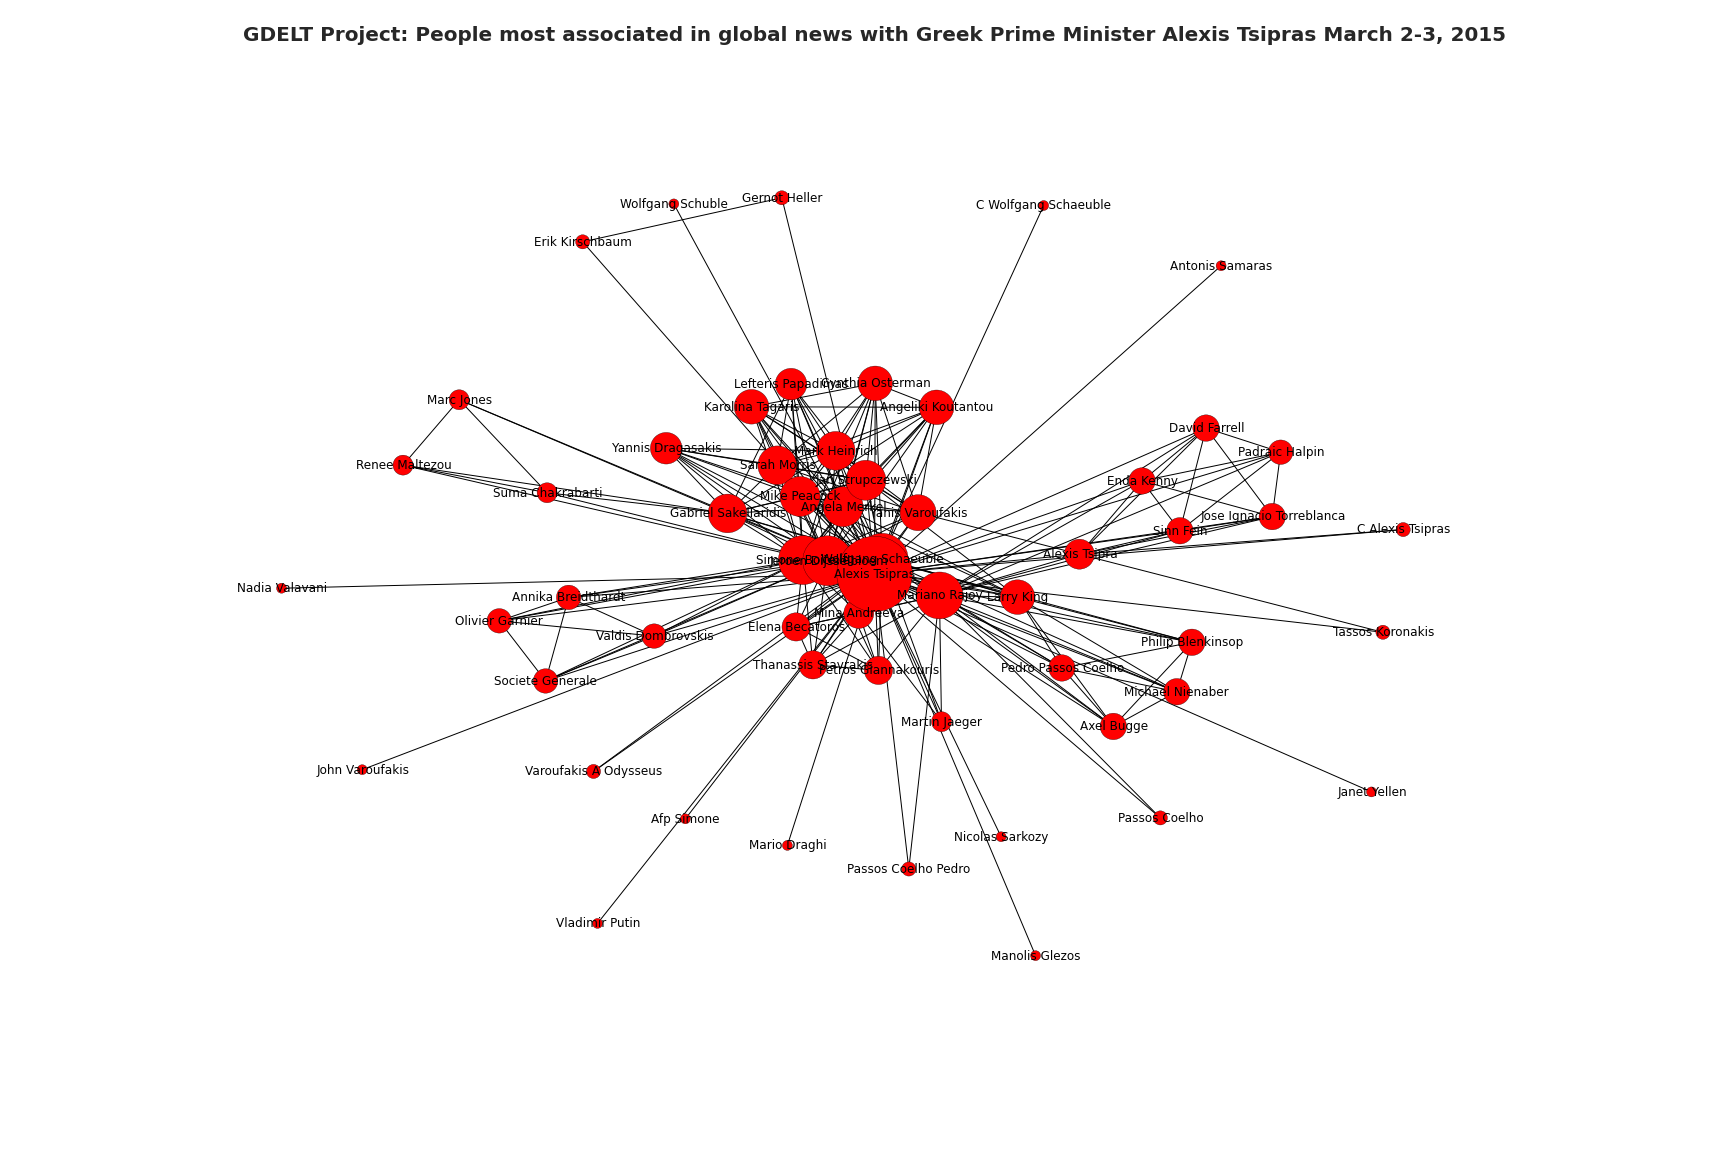

In [63]:
#now we'll get a bit more complex, sizing each node by its degree

g=nx.Graph()

for r in results.values:
  if 'Alexa' in r[0] or 'Alexa' in r[1]:
    continue
  g.add_edge(r[0],r[1], weight=r[2]/10)
  
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')

d=nx.degree(g)
nx.draw(g, nodelist=d.keys(), node_size=[v*100 for v in d.values()], with_labels=True)

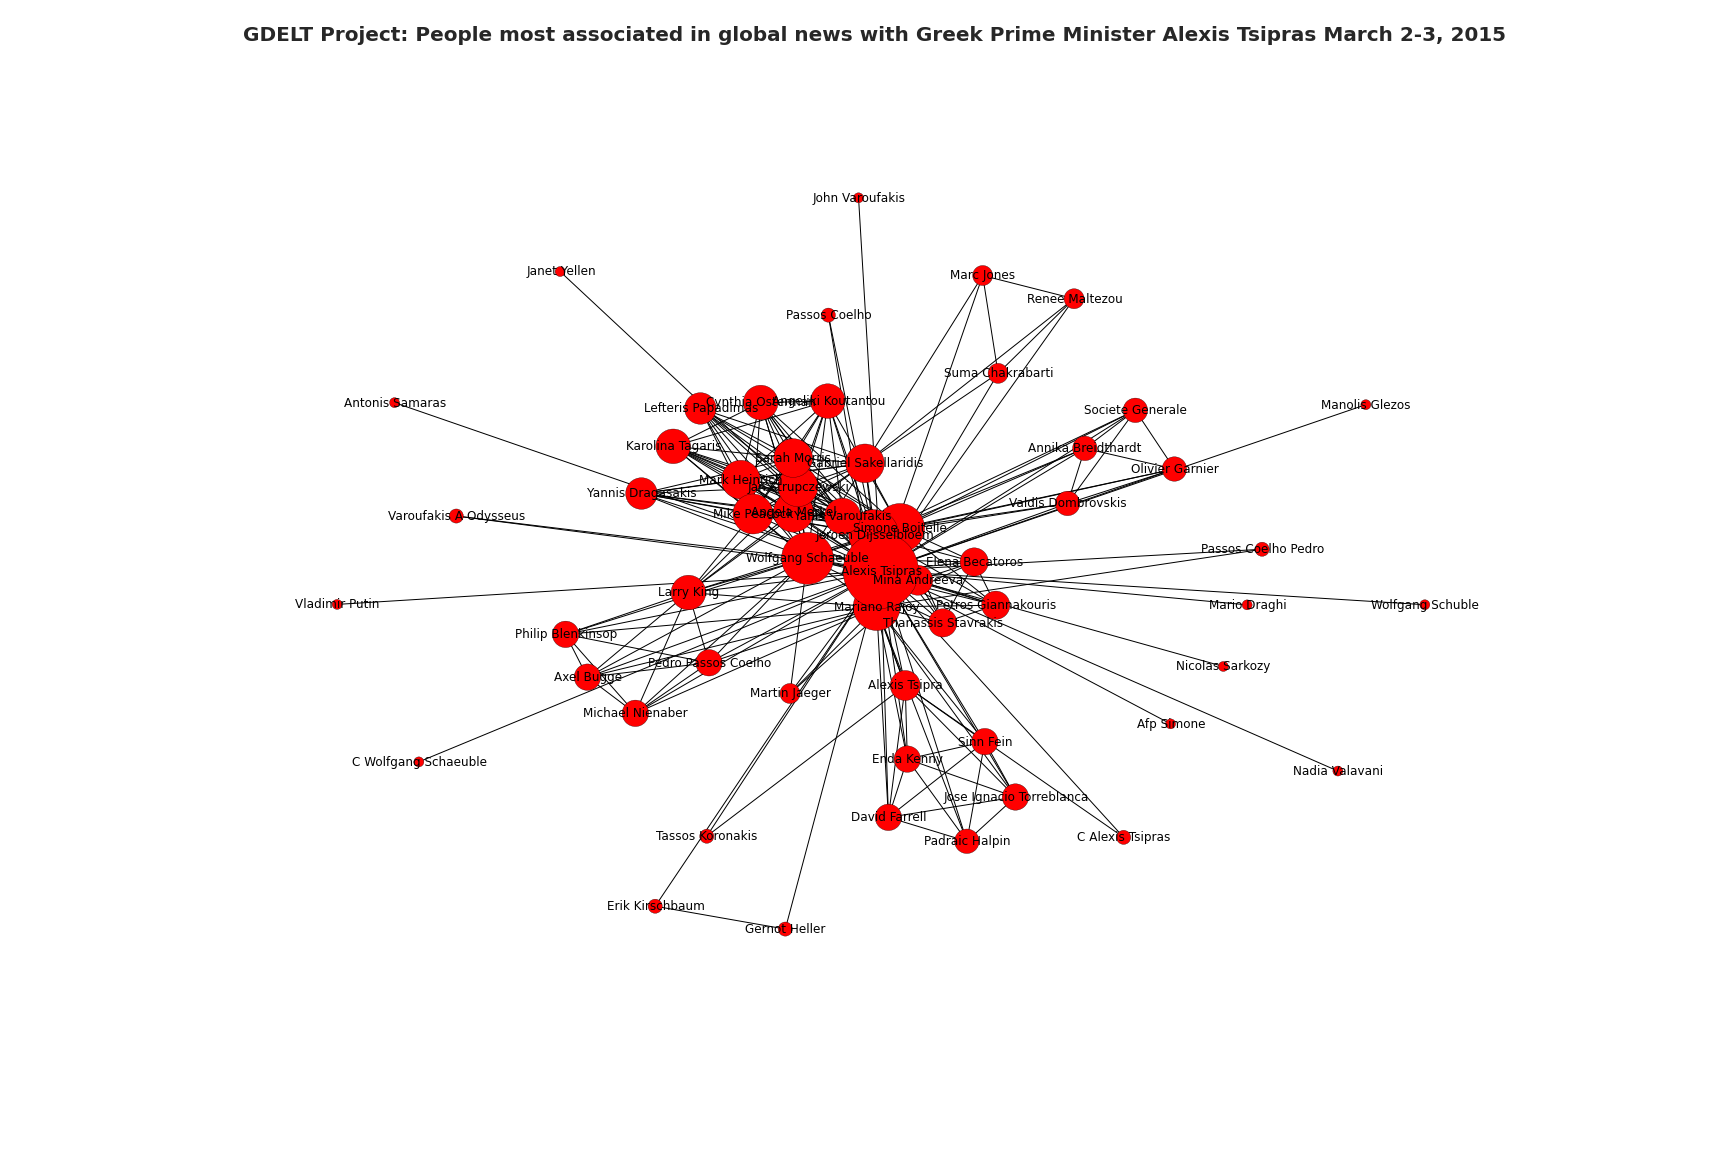

In [64]:
#instead of manually filtering out the isolate cluster we'll ask for the maximal connected component subgraph
#this yields the same output, but without requiring manual if/then logic

g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)
  
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
nx.draw(gmax, nodelist=d.keys(), node_size=[v*100 for v in d.values()], with_labels=True)

''

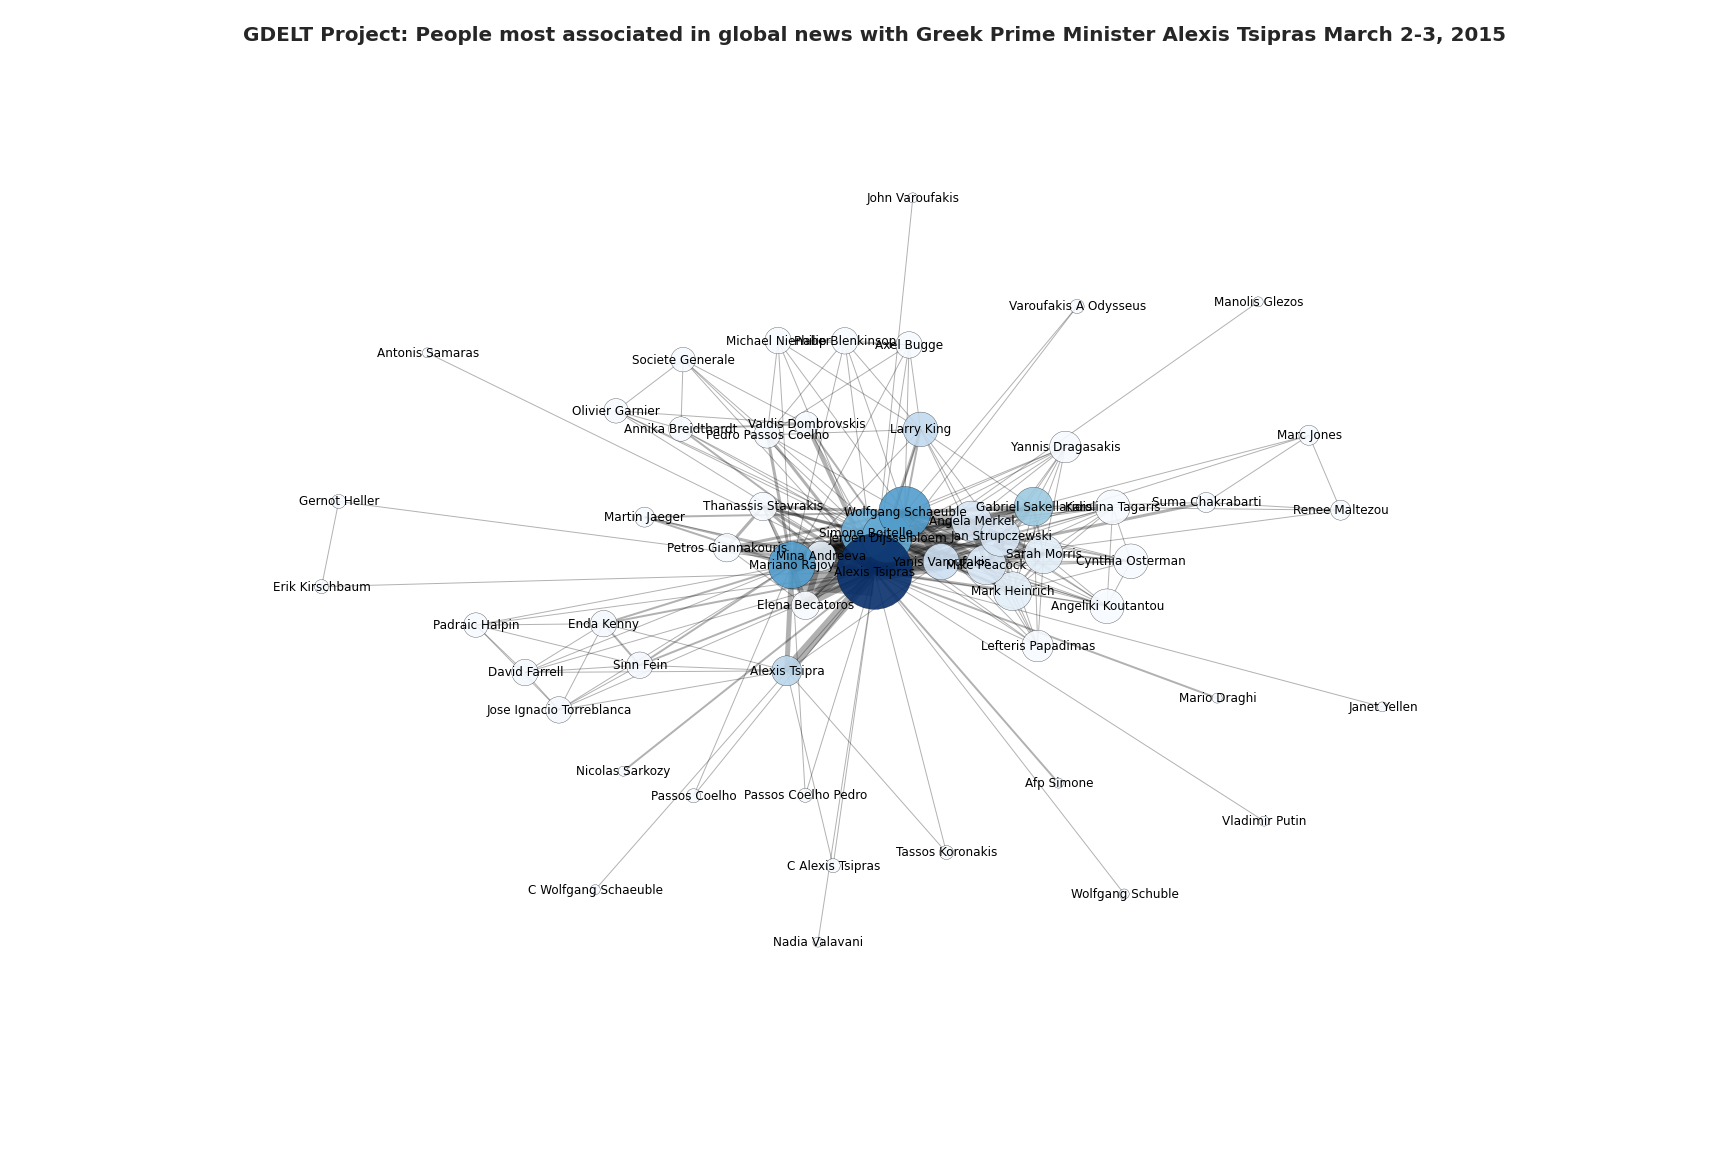

In [65]:
#here is a much more complex example, rendering the edges, nodes, and labels separately so that they can be independently styled and controlled
#this adds additional features to size edge width by strength and color nodes by betweenness centrality

import math

g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)

#set up with a white background and no grid lines
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')
cf=plt.gcf()
ax=cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

#use a standard spring layout - http://networkx.lanl.gov/reference/drawing.html
pos=nx.spring_layout(gmax)

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=False, alpha=0.3,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True, alpha=0.9,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_labels(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True,       
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

#add a final empty quote at the end to prevent IPython from outputting the full list of labels at the end
''

''

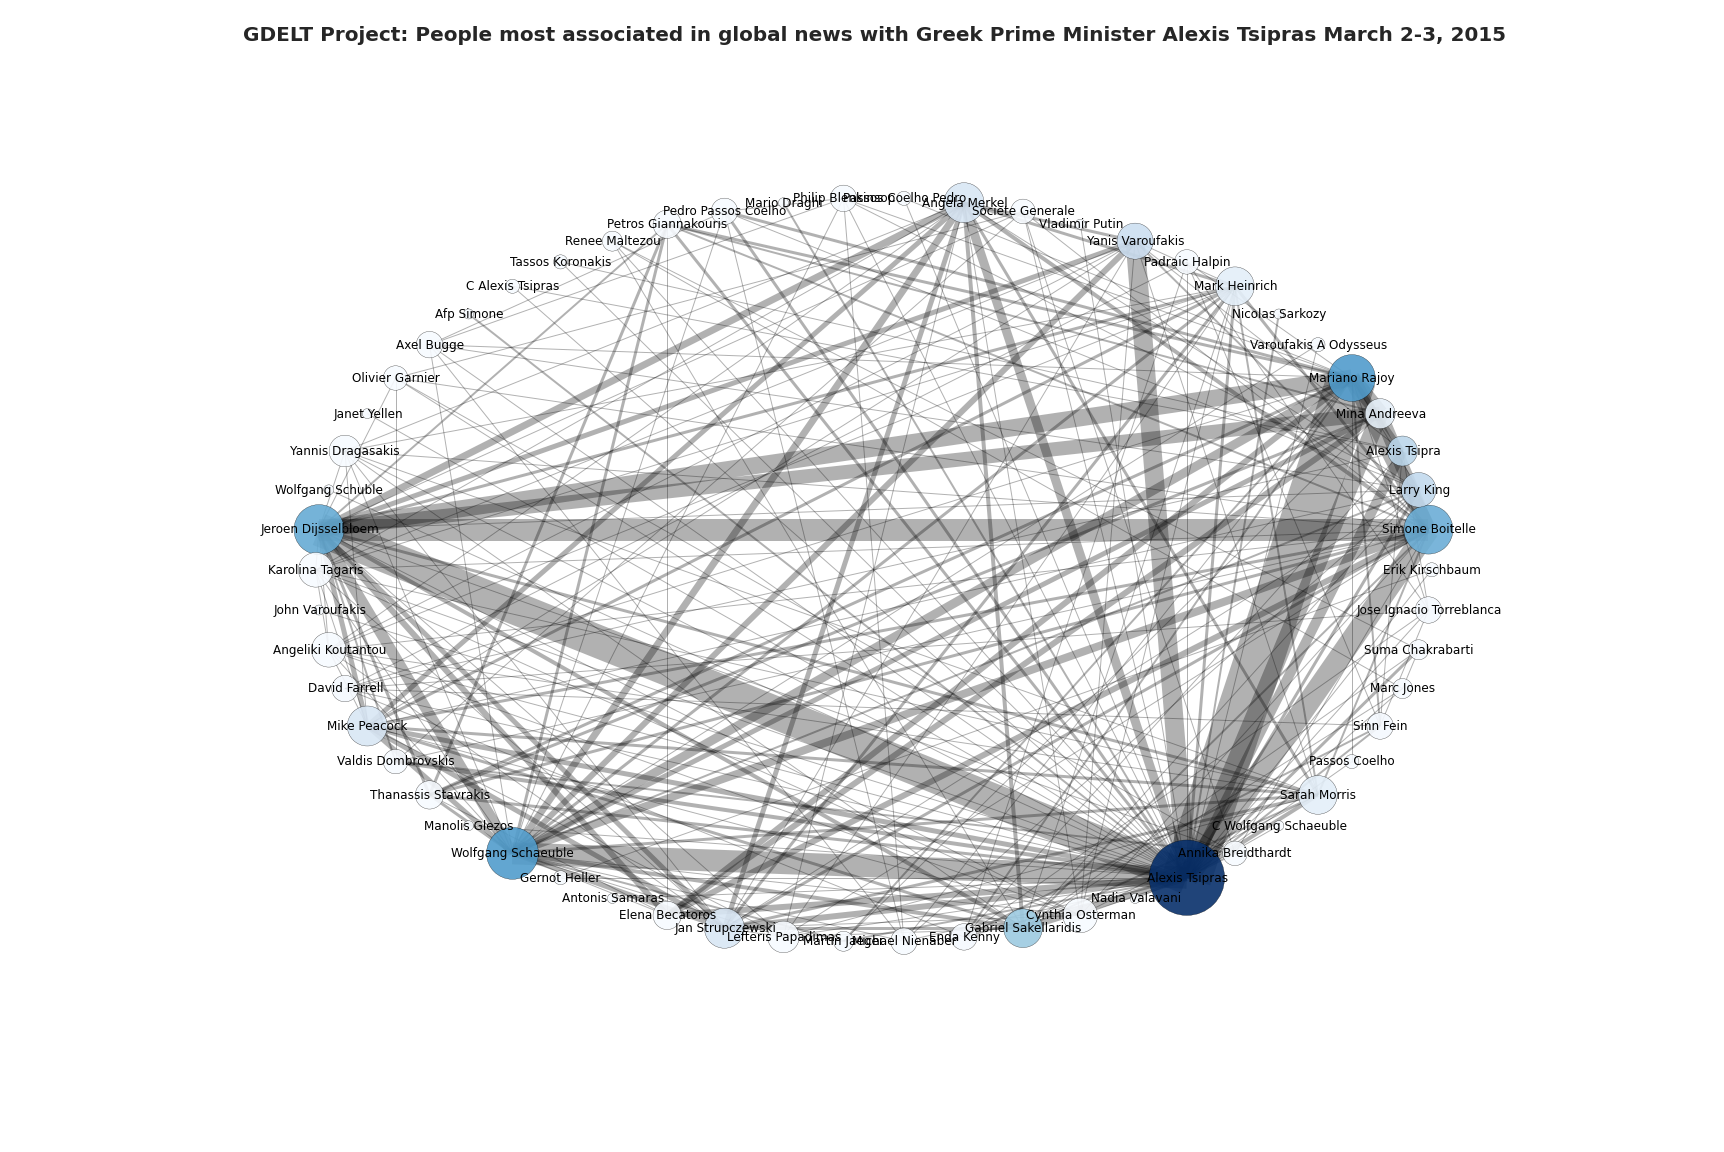

In [66]:
#same identical code as above, but here we change the layout algorithm to circular layout

import math

g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)

#set up with a white background and no grid lines
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')
cf=plt.gcf()
ax=cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

#use a circular layout - http://networkx.lanl.gov/reference/drawing.html
pos=nx.circular_layout(gmax)

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=False, alpha=0.3,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True, alpha=0.9,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_labels(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True,       
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

#add a final empty quote at the end to prevent IPython from outputting the full list of labels at the end
''

In [34]:
#first install modules needed to use GraphViz layout
#NOTE - you may have to shutdown and restart the session after doing this if you get errors about not being able to find the right executables

In [35]:
%%bash
/usr/bin/yes | apt-get install graphviz
pip install --upgrade graphviz
/usr/bin/yes | pip uninstall pyparsing
pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
pip install --upgrade pydot

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Requirement already up-to-date: graphviz in /usr/local/lib/python2.7/dist-packages
Cleaning up...
Not uninstalling pyparsing at /usr/lib/python2.7/dist-packages, owned by OS
Downloading/unpacking https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
  Running setup.py (path:/tmp/pip-cpaEmI-build/setup.py) egg_info for package from https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
    running egg_info
    creating pip-egg-info/pyparsing.egg-info
    writing pip-egg-info/pyparsing.egg-info/PKG-INFO
    writing top-level names to pip-egg-info/pyparsing.egg-info/top_level.txt
    writing dependency_links to pip-egg-info/pyparsing.egg-info/dependency_links.txt
    writing manifest file 'pip-egg-info/pyparsing.egg-info/SOURCES.txt'
    
    reading manifest file '

/usr/bin/yes: standard output: Broken pipe
/usr/bin/yes: write error
/usr/bin/yes: standard output: Broken pipe
/usr/bin/yes: write error


''

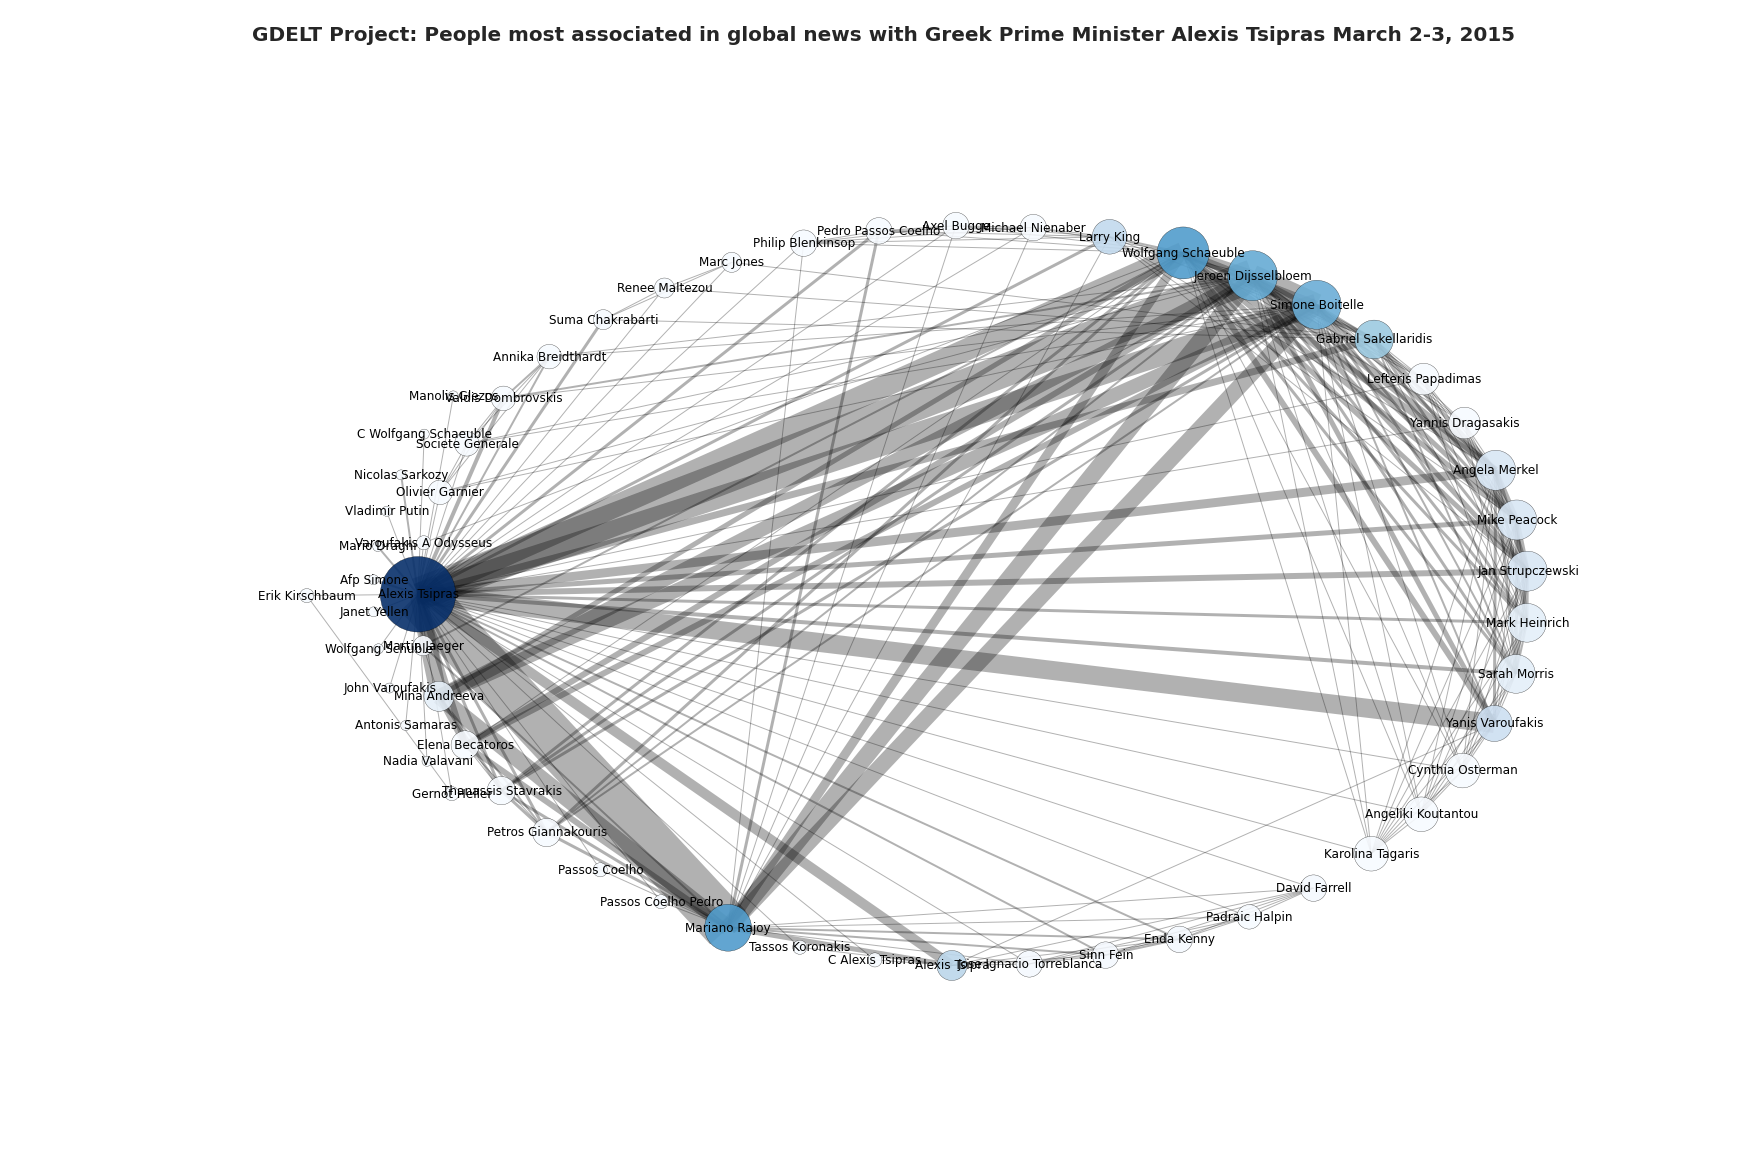

In [67]:
#same identical code as above, but here we change the layout algorithm to use Graphviz's circular layout, which often yields more clustered results

import math
import graphviz
import pydot


g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)

#set up with a white background and no grid lines
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')
cf=plt.gcf()
ax=cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

#use graphviz's engines - options for "prog" are: dot, neato, fdp, twopi, circo
pos=nx.graphviz_layout(gmax, prog='circo')

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=False, alpha=0.3,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True, alpha=0.9,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_labels(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True,       
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

#add a final empty quote at the end to prevent IPython from outputting the full list of labels at the end
''

''

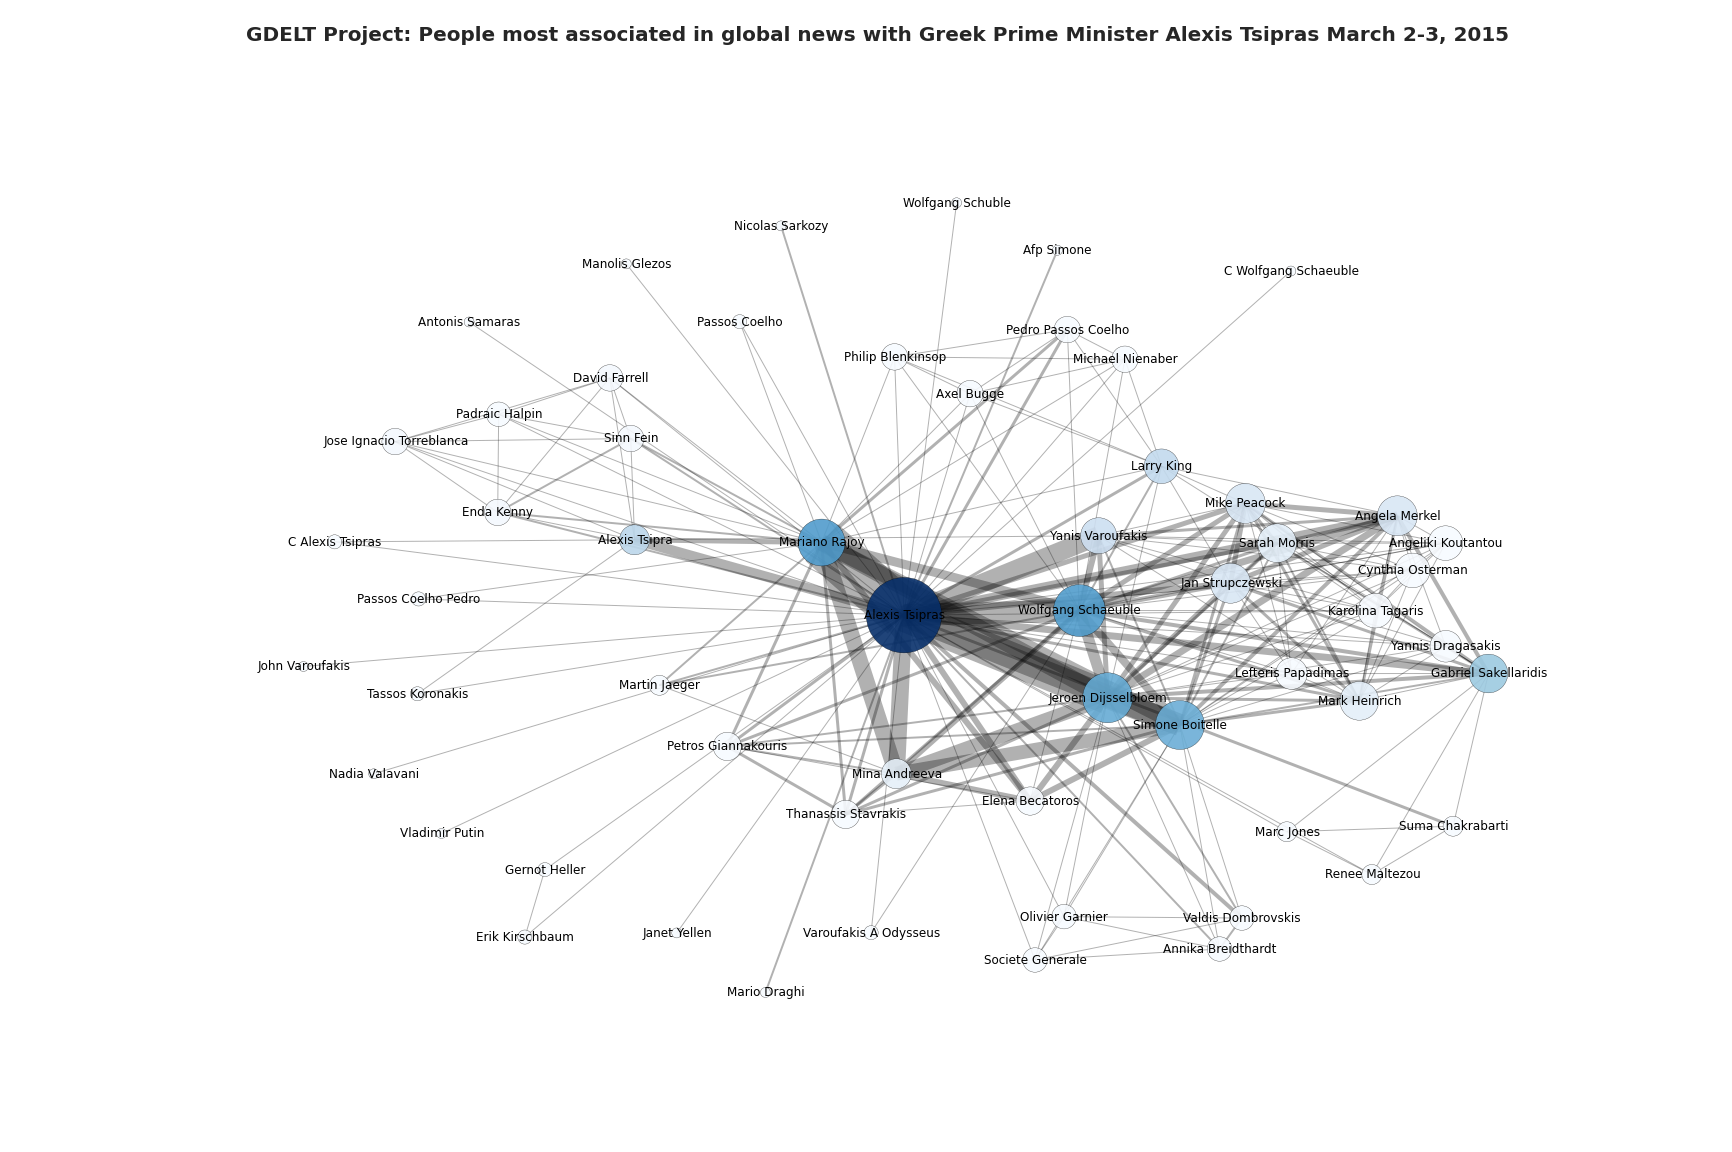

In [68]:
#same identical code as above, but here we change the layout algorithm to use Graphviz's "fdp" layout engine, which uses a global energy minimization function and tends to yield insightful clustering with nodes separated enough to be readable

import math
import graphviz
import pydot


g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)

#set up with a white background and no grid lines
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')
cf=plt.gcf()
ax=cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

#use graphviz's engines - options for "prog" are: dot, neato, fdp, twopi, circo
pos=nx.graphviz_layout(gmax, prog='fdp')

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=False, alpha=0.3,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True, alpha=0.9,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_labels(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True,       
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

#add a final empty quote at the end to prevent IPython from outputting the full list of labels at the end
''

''

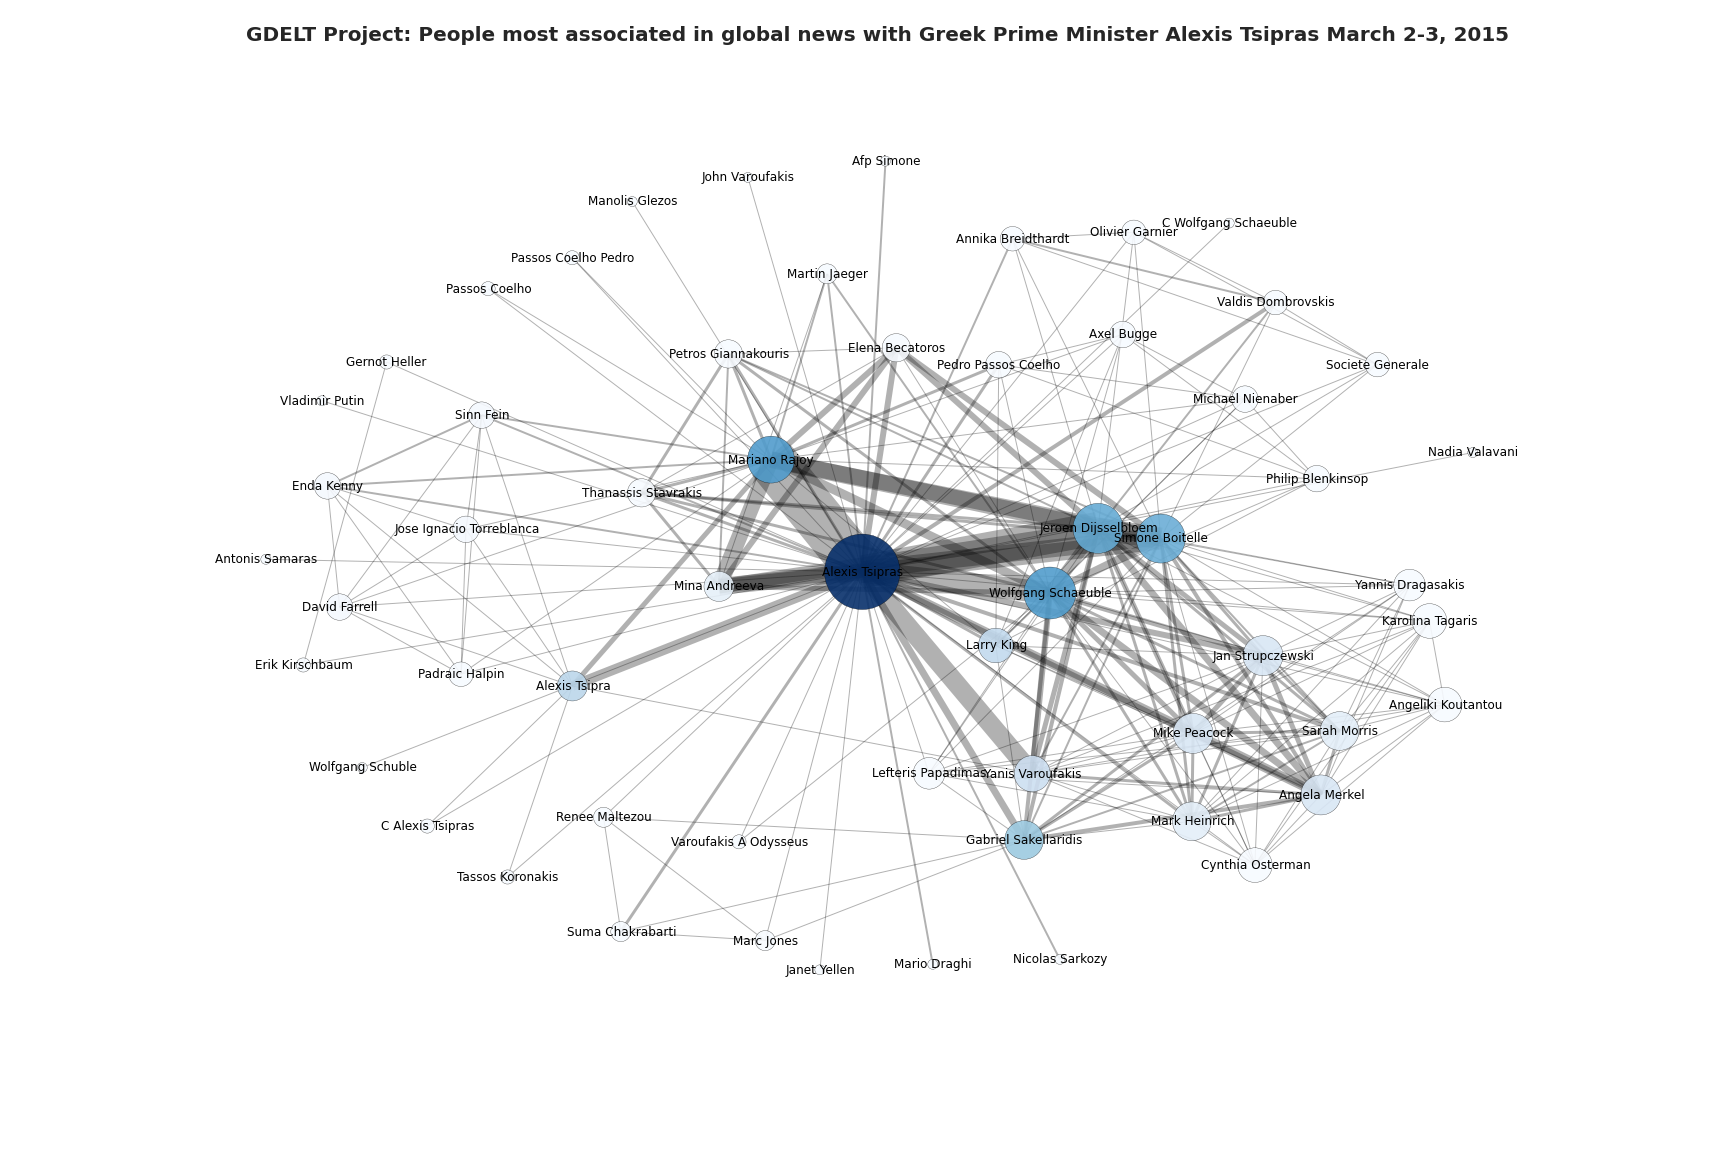

In [69]:
#same identical code as above, but here we change the layout algorithm to use Graphviz's "fdp" layout engine, which uses a global energy minimization function and tends to yield insightful clustering with nodes separated enough to be readable

import math
import graphviz
import pydot


g=nx.Graph()

for r in results.values:
  g.add_edge(r[0],r[1], weight=r[2]/10)

#set up with a white background and no grid lines
plt.figure(figsize=(30,20));
plt.title('GDELT Project: People most associated in global news with Greek Prime Minister Alexis Tsipras March 2-3, 2015', y=0.97, fontsize=20, fontweight='bold')
cf=plt.gcf()
ax=cf.gca()
ax.set_axis_off()

gmax = max(nx.connected_component_subgraphs(g), key=len)
d=nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

#use graphviz's engines - options for "prog" are: dot, neato, fdp, twopi, circo
pos=nx.graphviz_layout(gmax, prog='neato')

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=False, alpha=0.3,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True, alpha=0.9,
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])
nx.draw_networkx_labels(gmax, pos, nodelist=[v[0] for v in b], node_size=[d[v[0]]*100 for v in b],
        with_labels=True,       
        node_color = [math.log(1+v[1]*1000) for v in b], cmap=plt.cm.Blues,
       width=[gmax[u][v]['weight'] for u,v in gmax.edges()])

#add a final empty quote at the end to prevent IPython from outputting the full list of labels at the end
''